In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib 

In [2]:
def domino(lol):
    # Takes a list (length n) of lists (length 2)
    # and returns a list of indices order,
    # such that lol[order[i]] and lol[order[i+1]]
    # have at least one element in common.
    # If that is not possible, multiple
    # domino chains will be created.
    # This works in a greedy way.
    
    n = len(lol)
    order = [0] # Greedy 
    link = lol[0][-1]
    links = [lol[0][0],lol[0][1]]
    while len(order)<n:
        for i in [j for j in range(n) if not j in order]:
            if link in lol[i]: # They connect
                order.append(i) # Save the id of the "stone"
                link = lol[i][0] if not(lol[i][0]==link) else lol[i][1] # The new link is the other element 
                links.append(link)
                break
    return order,links[:-1]

In [121]:
prefix="l"
qt = "2"
xyz = np.loadtxt(f"{qt}{prefix}points.txt")
origw = np.loadtxt(f"{qt}{prefix}weights.txt")
neighbours = np.loadtxt(f"{qt}{prefix}neighbours.txt",dtype=int)-1 # julia starts at 1
triangles = np.loadtxt(f"{qt}{prefix}triangles.txt",dtype=int)-1 # julia starts at 1 
nq = len(origw)
steps = 10 # for colorbar

w = np.round(origw,6)
suw = np.sort(np.unique(w))
print(suw)

[0.002054 0.003377 0.003835 0.00396  0.004513 0.004623 0.00528  0.005348
 0.005352 0.006115 0.006118 0.00629  0.006873 0.006975 0.007308 0.007424
 0.007546 0.007794 0.008058 0.008335 0.008336 0.008481 0.00863  0.008942
 0.009106 0.009274 0.009811 0.010001 0.010401 0.010828 0.011285 0.011525
 0.011774 0.012299 0.012576 0.012864 0.013473 0.013796 0.014131]


/home/qd4314/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


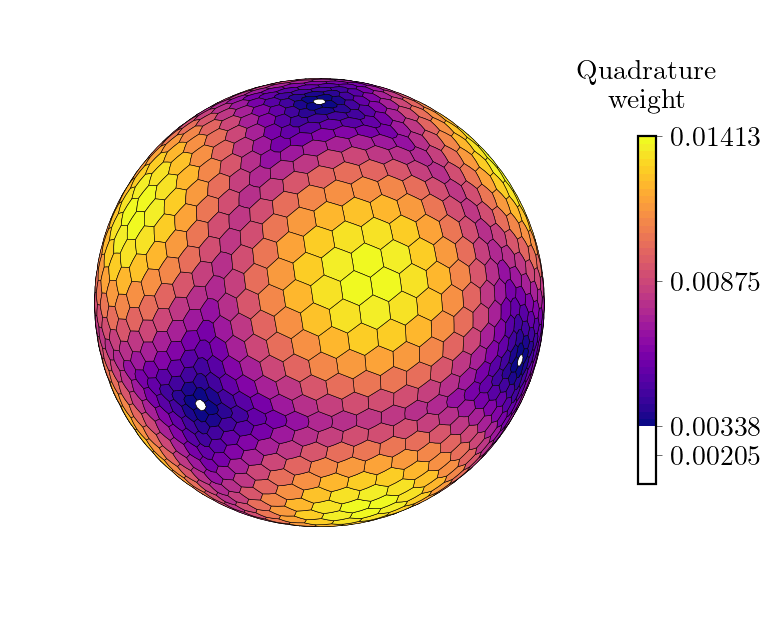

In [122]:
plt.style.use("kitishblank")
fig = plt.figure(figsize=plt.figaspect(0.8)) #Adjusts the aspect ratio and enlarges the figure (text does not enlarge)
ax = fig.gca(projection='3d')

cmap = plt.cm.plasma
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', cmaplist, cmap.N)
#suw = suw[1:]
# define the bins and normalize
bounds = (suw[1:]+suw[:-1])/2
bounds = np.insert(bounds,0,suw[0]-(bounds[0]-suw[0]))
bounds = np.insert(bounds,len(bounds),suw[-1]+(suw[-1]-bounds[-1]))
bounds = np.linspace(suw[1],suw[-1],len(suw)+1)
cmap.set_under('1')
norm = matplotlib.colors.BoundaryNorm(bounds ,cmap.N+1)


for center in range(nq):
    lol = [] # list of lists
    for i in neighbours[center,:]:
        if i>-1:
            lol.append(list(np.sort(triangles[i,triangles[i,:] != center])))
    order,links = domino(lol)
 
    neighx = [xyz[j,0] for j in links]
    neighy = [xyz[j,1] for j in links]
    neighz = [xyz[j,2] for j in links]

    # Get the actual hexagon that surrounds a center point
    x = []
    y = []
    z = []
    for i in range(len(order)):
        x.append((xyz[center,0]+neighx[i]) / 2)
        x.append((xyz[center,0]+neighx[i]+neighx[(i+1)%len(order)])/3)

        y.append((xyz[center,1]+neighy[i]) / 2)
        y.append((xyz[center,1]+neighy[i]+neighy[(i+1)%len(order)])/3)
        
        z.append((xyz[center,2]+neighz[i]) / 2)
        z.append((xyz[center,2]+neighz[i]+neighz[(i+1)%len(order)])/3)
        
    # Project onto sphere
    #for i in range(len(order)):
    #    tmp = (x[i]**2+y[i]**2+z[i]**2)**0.5
    #    x[i]/=tmp
    #    y[i]/=tmp
    #    z[i]/=tmp
    
    verts = [list(zip(x,y,z))]
    
    rgb = cmap(norm(w[center]))
    
    ax.add_collection3d(Poly3DCollection(verts,facecolor = rgb,linewidth=0.2,edgecolor="k"))
    p= ax.scatter(0*xyz[center,0],0*xyz[center,1],0*xyz[center,2],color=rgb,cmap=cmap)
l = 0.7
ax.set_xlim([-l,l])
ax.set_ylim([-l,l])
ax.set_zlim([-l,l])
plt.tight_layout()
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis("off")
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

centers = (bounds[1:]+bounds[:-1])/2

lowest = suw[1] - 0.2*(suw[-1]-suw[1])
ticks = [(lowest+suw[1])/2, suw[1], (suw[1] + suw[-1])/2, suw[-1]]
#ticks = centers[::steps]
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax,shrink = 0.6,
                   ticks =ticks,boundaries = np.insert(bounds,0,lowest),spacing="proportional")

ticks = [suw[0], suw[1], (suw[1] + suw[-1])/2, suw[-1]]
cbar.ax.set_yticklabels(["{:06.5f}".format(bi) for bi in ticks])

#cbar.ax.set_yticklabels(["{:06.5f}".format(bi) for bi in bounds[::step]])
cbar.ax.set_title("Quadrature \n weight")

fig.tight_layout()
fig.savefig("oct{}{}.pdf".format(prefix,nq))
